# Diffusion Maps + KSWGD Generative Modelling on MNIST

This notebook implements an autoencoder + diffusion-maps latent analysis, then mirrors the KSWGD scheme from Tests 1 & 2 to sample new MNIST digits directly in latent space.

**Pipeline:**

1. Load MNIST and normalize images.
2. Train an autoencoder (either MLP-based or CNN-based) to learn a low-dimensional latent space.
3. Map training images to latent codes.
4. Apply Diffusion Maps on latent codes to obtain diffusion coordinates for diagnostics.
5. Build the KSWGD kernel operators on the latent samples (same normalization as Tests 1 & 2).
6. Run KSWGD particle transport to draw new latent vectors.
7. Decode KSWGD latent vectors back to images and visually inspect generated digits.


In [1]:
# Configure core libraries, plotting defaults, and compute device
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_AVAILABLE = True
except Exception:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_AVAILABLE = False

np.random.seed(1)
torch.manual_seed(1)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu_kswgd = bool(GPU_AVAILABLE and torch.cuda.is_available())

print("=" * 50)
print("GPU Info")
print("=" * 50)
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}, Memory: {props.total_memory / 1024**3:.2f} GB")
else:
    print("No CUDA GPU available")

print(f"\nUsing device: {device}")
print(f"KSWGD GPU backend: {'enabled' if use_gpu_kswgd else 'disabled'}")

c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU Info
CUDA version: 12.1
cuDNN version: 90100
Number of GPUs: 1
GPU 0: NVIDIA RTX 4000 SFF Ada Generation, Memory: 19.99 GB

Using device: cuda
KSWGD GPU backend: enabled


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
# Load MNIST datasets and build training/test data loaders
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 60000 Test size: 10000


In [3]:
# Define the fully connected autoencoder blocks used for the MLP baseline
latent_dim = 6  # dimension of the latent space

class MLPEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLPDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x_flat = self.net(z)
        return x_flat.view(-1, 1, 28, 28)


class MLPAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = MLPEncoder(latent_dim)
        self.decoder = MLPDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [4]:
# Define the convolutional autoencoder architecture for improved spatial modeling
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # 1x28x28 -> 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x28x28 -> 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 64x14x14 -> 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 7 * 7),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x7x7 -> 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # 64x14x14 -> 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # 32x28x28 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 128, 7, 7)
        x = self.deconv(h)
        return x


class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [5]:
# Choose which autoencoder variant to train and move it to the target device
# Option 1: MLP autoencoder
# autoencoder = MLPAutoencoder(latent_dim=latent_dim).to(device)

# Option 2: CNN autoencoder (default here)
autoencoder = CNNAutoencoder(latent_dim=latent_dim).to(device)

print(autoencoder)


CNNAutoencoder(
  (encoder): CNNEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=6272, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=6, bias=True)
    )
  )
  (decoder): CNNDecoder(
    (fc): Sequential(
      (0): Linear(in_features=6, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=6272, bias=True)
 

In [6]:
# Train the selected autoencoder on MNIST with Adam, validation, and per-class loss analysis
num_epochs = 100
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

best_val_loss = float("inf")
best_epoch = 0

for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon, z = autoencoder(images)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon, _ = autoencoder(images)
            val_loss += criterion(recon, images).item()

    avg_val_loss = val_loss / len(test_loader)

    # Track best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1

    print(f"Epoch [{epoch+1:2d}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print(f"\nBest validation loss: {best_val_loss:.4f} at epoch {best_epoch}")

Epoch [ 1/100] | Train Loss: 0.0322 | Val Loss: 0.0223
Epoch [ 2/100] | Train Loss: 0.0209 | Val Loss: 0.0198
Epoch [ 3/100] | Train Loss: 0.0193 | Val Loss: 0.0189
Epoch [ 4/100] | Train Loss: 0.0184 | Val Loss: 0.0181
Epoch [ 5/100] | Train Loss: 0.0178 | Val Loss: 0.0179
Epoch [ 6/100] | Train Loss: 0.0174 | Val Loss: 0.0175
Epoch [ 7/100] | Train Loss: 0.0170 | Val Loss: 0.0173
Epoch [ 8/100] | Train Loss: 0.0167 | Val Loss: 0.0169
Epoch [ 9/100] | Train Loss: 0.0164 | Val Loss: 0.0168
Epoch [10/100] | Train Loss: 0.0162 | Val Loss: 0.0169
Epoch [11/100] | Train Loss: 0.0160 | Val Loss: 0.0168
Epoch [12/100] | Train Loss: 0.0158 | Val Loss: 0.0165
Epoch [13/100] | Train Loss: 0.0156 | Val Loss: 0.0166
Epoch [14/100] | Train Loss: 0.0155 | Val Loss: 0.0165
Epoch [15/100] | Train Loss: 0.0153 | Val Loss: 0.0164
Epoch [16/100] | Train Loss: 0.0152 | Val Loss: 0.0163
Epoch [17/100] | Train Loss: 0.0151 | Val Loss: 0.0164
Epoch [18/100] | Train Loss: 0.0150 | Val Loss: 0.0162
Epoch [19/

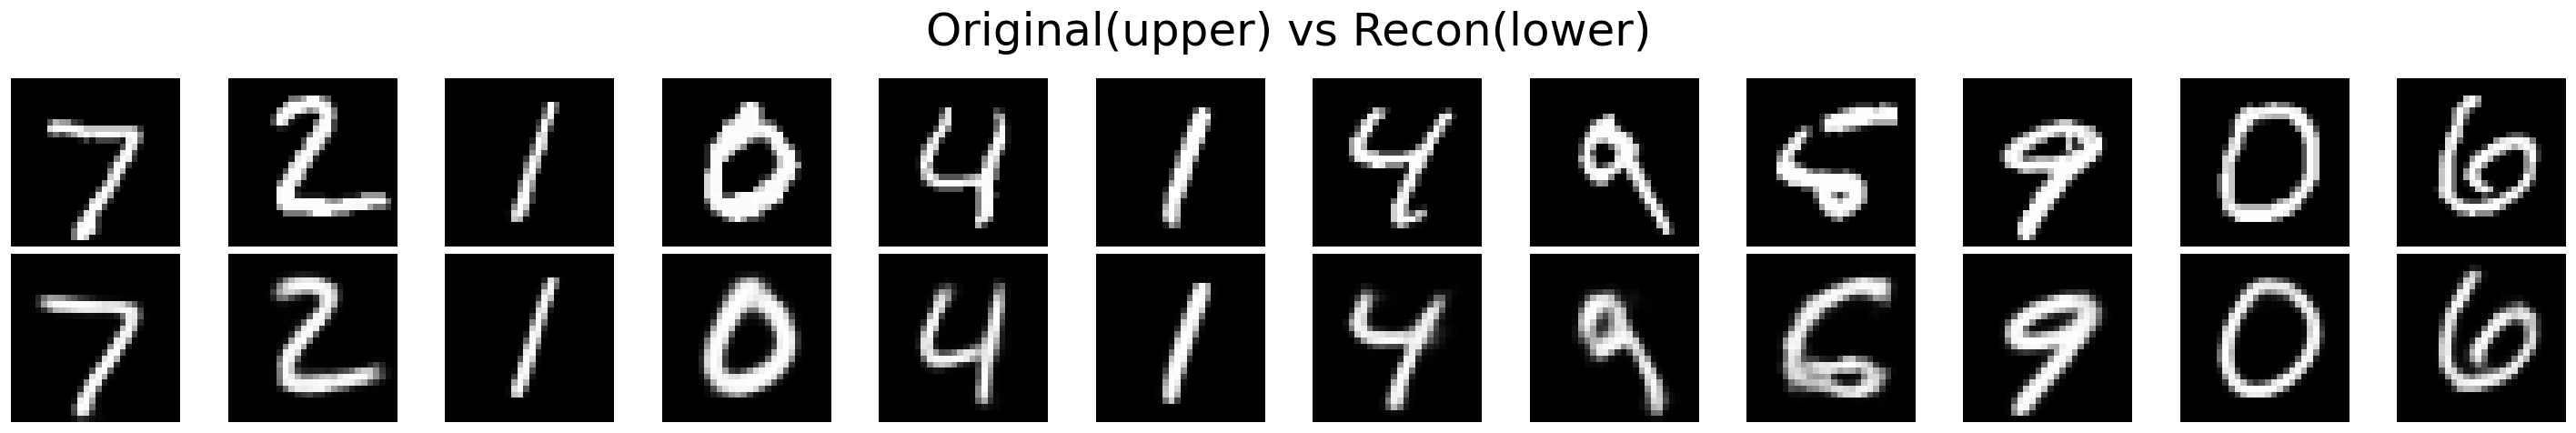

In [7]:
# Visualize a batch of original vs reconstructed digits to sanity-check training
autoencoder.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    recon, _ = autoencoder(images)

images_cpu = images.cpu().numpy()
recon_cpu = recon.cpu().numpy()

n_show = 12
fig, axes = plt.subplots(2, n_show, figsize=(2 * n_show, 4))
fig.suptitle("Original(upper) vs Recon(lower)", fontsize=30)
for i in range(n_show):
    axes[0, i].imshow(images_cpu[i, 0], cmap="gray")
    axes[0, i].axis("off")
    # axes[0, i].set_title("Original (DM)", fontsize=20)
    axes[1, i].imshow(recon_cpu[i, 0], cmap="gray")
    axes[1, i].axis("off")
    # axes[1, i].set_title("Recon (DM)", fontsize=20)
plt.tight_layout()
plt.show()


In [8]:
# Encode the full training set to collect latent vectors and labels for DM
autoencoder.eval()

all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, z = autoencoder(images)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

Z = np.concatenate(all_latents, axis=0)   # shape (N, latent_dim)
y_labels = np.concatenate(all_labels, axis=0)

print("Latent codes shape:", Z.shape)


Latent codes shape: (60000, 6)


In [9]:
# Prepare the latent sample subset and kernel matrix required for diffusion maps
# Subsample for Diffusion Maps (e.g., 5000 points) with stratified sampling to keep label balance
max_dm_samples = 5000
N_total = Z.shape[0]

if N_total > max_dm_samples:
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=max_dm_samples, random_state=42)
    idx_dm, _ = next(splitter.split(Z, y_labels))
else:
    idx_dm = np.arange(N_total)

Z_dm_raw = Z[idx_dm]
labels_dm = y_labels[idx_dm]

# ========== STANDARDIZE latent codes for DM ==========
# This ensures all dimensions have similar scale for proper kernel computation
Z_dm_mean = np.mean(Z_dm_raw, axis=0, keepdims=True)
Z_dm_std = np.std(Z_dm_raw, axis=0, keepdims=True) + 1e-8
Z_dm = (Z_dm_raw - Z_dm_mean) / Z_dm_std  # Standardized latent codes
print(f"Standardized Z_dm: mean~{Z_dm.mean():.4f}, std~{Z_dm.std():.4f}")
# =====================================================

unique_labels, label_counts = np.unique(labels_dm, return_counts=True)
label_hist = {int(lbl): int(cnt) for lbl, cnt in zip(unique_labels, label_counts)}
print("Latent points used for DM:", Z_dm.shape)
print("Label histogram in DM subset:", label_hist)

# Pairwise distances (now on standardized data)
dists = pairwise_distances(Z_dm, metric="euclidean")

# Epsilon via median heuristic (can adjust multiplier for better separation)
med_sq = np.median(dists**2)
eps = med_sq / (2.0 * np.log(Z_dm.shape[0]))
# Alternative: use a smaller epsilon for tighter clustering
# eps = np.percentile(dists**2, 10)  # 10th percentile for local structure
print("Chosen epsilon:", eps)
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Gaussian kernel
K = np.exp(-dists**2 / (2.0 * eps))

# Row-normalize -> Markov matrix P
row_sums = K.sum(axis=1, keepdims=True)
P = K / row_sums

Standardized Z_dm: mean~0.0000, std~1.0000
Latent points used for DM: (5000, 6)
Label histogram in DM subset: {0: 493, 1: 562, 2: 496, 3: 511, 4: 487, 5: 452, 6: 493, 7: 522, 8: 488, 9: 496}
Chosen epsilon: 0.5818227527137849
Distance stats: min=0.0766, median=3.1482, max=12.4373


In [10]:
# Compute the leading diffusion-map eigenpairs to obtain coordinates and spectra
m = 15  # number of eigenvectors
t_diffusion = 1  # diffusion time for scaling coordinates

vals, vecs = eigs(P.T, k=m, which="LR")

idx_sort = np.argsort(-np.abs(vals))
vals = vals[idx_sort]
vecs = vecs[:, idx_sort]

lam = np.real(vals)
phi_raw = np.real(vecs)

# Scale diffusion coordinates by eigenvalues^t (standard Diffusion Maps embedding)
# This amplifies the coordinates to show structure at different scales
phi = phi_raw * (lam[np.newaxis, :] ** t_diffusion)

print("Leading eigenvalues:", lam)
print(f"Diffusion coords range: [{phi[:, 1:].min():.4f}, {phi[:, 1:].max():.4f}]")


Leading eigenvalues: [1.         0.99997098 0.99995799 0.99994207 0.9999313  0.99984435
 0.99983564 0.99877967 0.99832958 0.99556216 0.99474242 0.99122232
 0.98626547 0.98291769 0.98235955]
Diffusion coords range: [-0.9998, 0.9998]


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=20.
  warnings.warn(


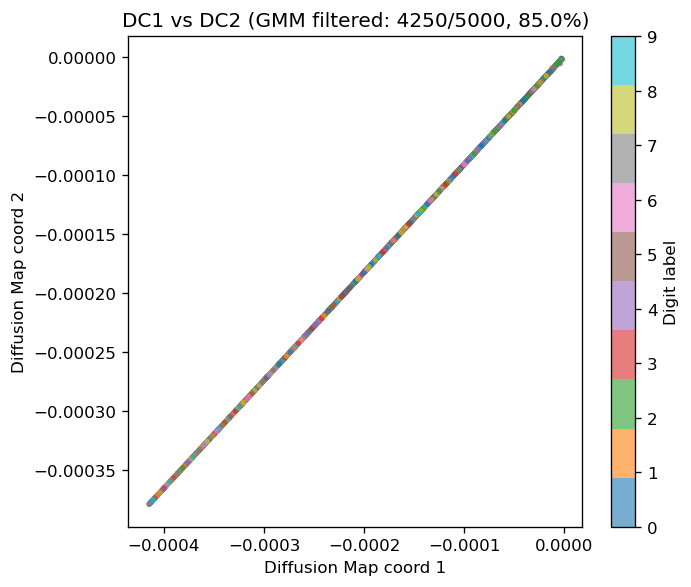

c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=20.
  warnings.warn(


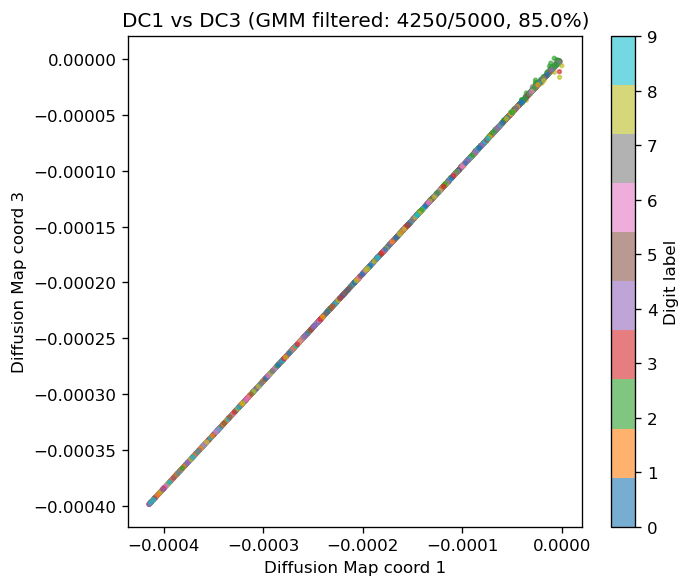

c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=20.
  warnings.warn(


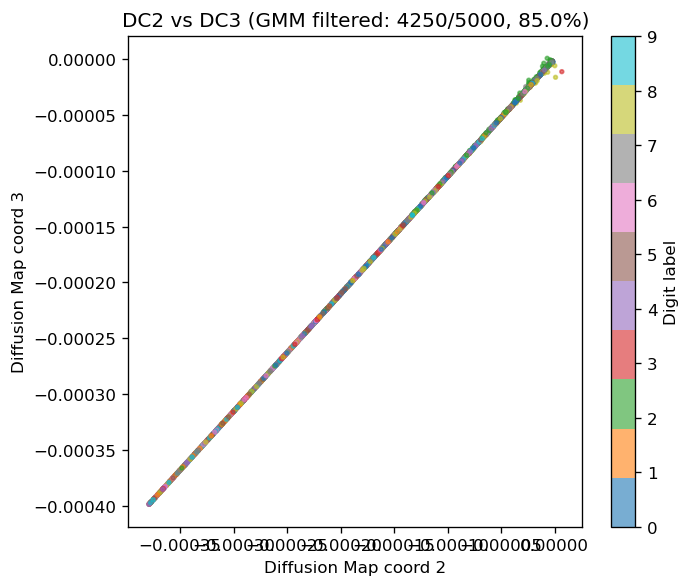

In [11]:
# Plot several diffusion-coordinate pairs with GMM outlier filtering (keep ~90% of points)
from sklearn.mixture import GaussianMixture

# GMM outlier filtering parameters
n_gmm_components_2d = 10  # number of GMM components
outlier_percentile = 15   # remove bottom 10% by GMM log-likelihood (keep 90%)

pairs = [(1, 2), (1, 3), (2, 3)]
for i, j in pairs:
    dc_i = phi[:, i]
    dc_j = phi[:, j]
    coords_2d = np.column_stack([dc_i, dc_j])
    
    # Fit GMM and compute log-likelihood scores
    gmm_2d = GaussianMixture(n_components=n_gmm_components_2d, covariance_type='full', random_state=42)
    gmm_2d.fit(coords_2d)
    log_probs_2d = gmm_2d.score_samples(coords_2d)
    
    # Keep top 90% by log-likelihood (filter out bottom 10% outliers)
    threshold_2d = np.percentile(log_probs_2d, outlier_percentile)
    inlier_mask_2d = log_probs_2d >= threshold_2d
    
    n_total = len(dc_i)
    n_kept = np.sum(inlier_mask_2d)
    
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(dc_i[inlier_mask_2d], dc_j[inlier_mask_2d], 
                          c=labels_dm[inlier_mask_2d], s=5, alpha=0.6, cmap="tab10")
    plt.xlabel(f"Diffusion Map coord {i}")
    plt.ylabel(f"Diffusion Map coord {j}")
    plt.title(f"DC{i} vs DC{j} (GMM filtered: {n_kept}/{n_total}, {100*n_kept/n_total:.1f}%)")
    plt.colorbar(scatter, label="Digit label")
    plt.tight_layout()
    plt.show()

Raw coordinate ranges (before filtering):
  DC1: [-0.0007, 0.9988]
  DC2: [-0.0444, 0.9988]
  DC3: [-0.0007, 0.9997]

IQR pre-filter: removed 7 extreme points (0.1%)
GMM filter: removed additional 500 points
Total outliers removed: 507 (10.1%)
Inliers kept: 4493

Filtered & scaled coordinate ranges (SPREAD_FACTOR=1.0):
  DC1: [-1.577, 0.940]
  DC2: [-1.577, 0.917]
  DC3: [-1.575, 1.046]


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=20.
  warnings.warn(


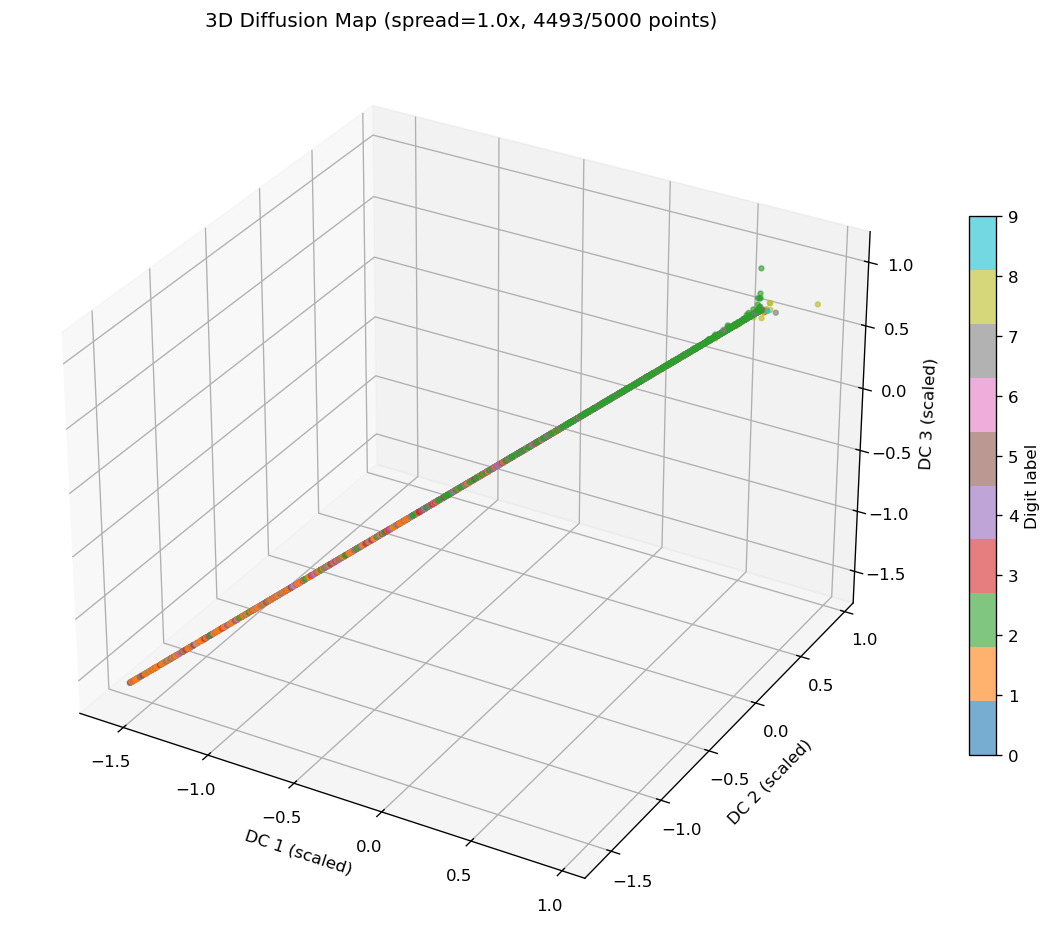

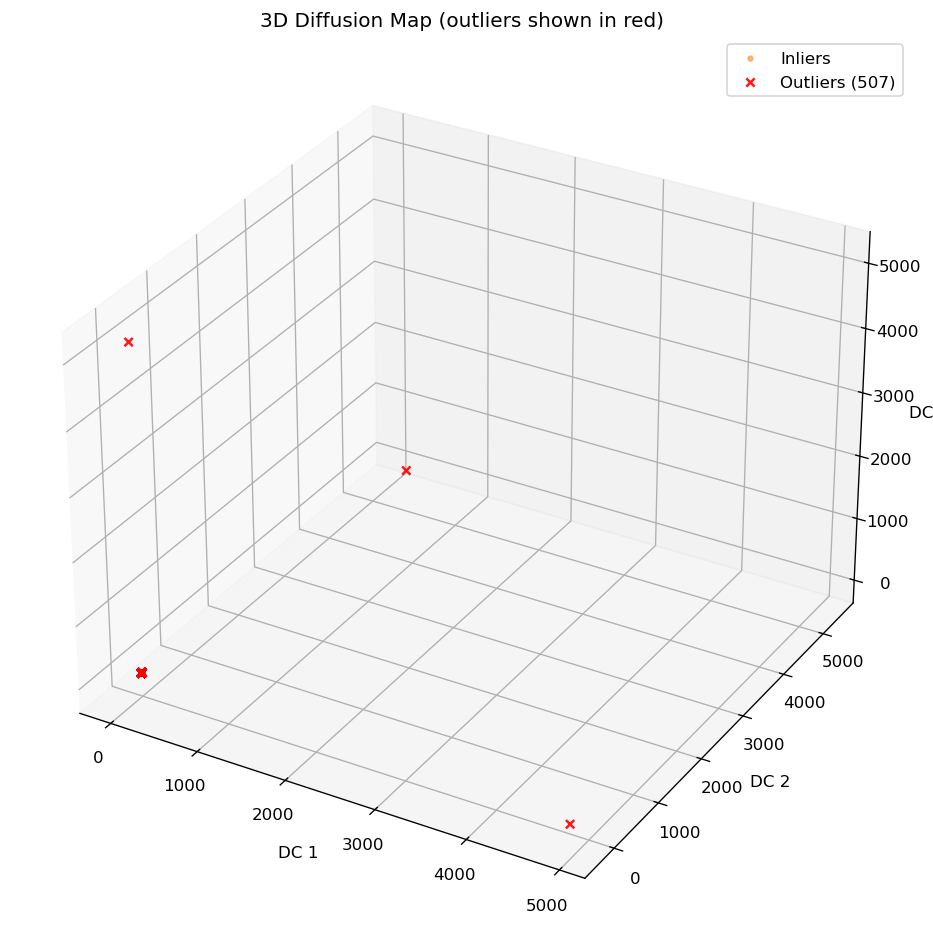

In [12]:
# 3D diffusion-coordinate visualization with GMM outlier filtering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D

# ============== RESCALE PARAMETER ==============
# Increase this value to spread clusters further apart
# Typical values: 1.0 (no change), 2.0-5.0 (moderate spread), 5.0-10.0 (large spread)
SPREAD_FACTOR = 1.0  # <-- Adjust this to control cluster separation
# ===============================================

# Use first 3 nontrivial diffusion coordinates for 3D plot
# Scale by eigenvalues to get proper diffusion distances (standard practice)
dc_1_raw = phi[:, 1] * lam[1]
dc_2_raw = phi[:, 2] * lam[2]
dc_3_raw = phi[:, 3] * lam[3]
coords_3d_raw = np.column_stack([dc_1_raw, dc_2_raw, dc_3_raw])

print(f"Raw coordinate ranges (before filtering):")
print(f"  DC1: [{dc_1_raw.min():.4f}, {dc_1_raw.max():.4f}]")
print(f"  DC2: [{dc_2_raw.min():.4f}, {dc_2_raw.max():.4f}]")
print(f"  DC3: [{dc_3_raw.min():.4f}, {dc_3_raw.max():.4f}]")

# Step 1: First pass - use IQR to remove extreme outliers before GMM
def iqr_filter(data, factor=3.0):
    """Remove points outside factor*IQR from Q1/Q3"""
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = np.all((data >= lower) & (data <= upper), axis=1)
    return mask

iqr_mask = iqr_filter(coords_3d_raw, factor=2.5)
print(f"\nIQR pre-filter: removed {np.sum(~iqr_mask)} extreme points ({100*np.sum(~iqr_mask)/len(iqr_mask):.1f}%)")

# Step 2: Fit GMM on IQR-filtered data for finer outlier detection
coords_filtered = coords_3d_raw[iqr_mask]
n_gmm_components = 10
gmm = GaussianMixture(n_components=n_gmm_components, covariance_type='full', random_state=42)
gmm.fit(coords_filtered)

# Score ALL points with the GMM trained on filtered data
log_probs_all = gmm.score_samples(coords_3d_raw)
# Use a more aggressive threshold: bottom 5% of GMM scores
threshold = np.percentile(log_probs_all[iqr_mask], 10)
gmm_mask = log_probs_all >= threshold

# Combine both filters
inlier_mask = iqr_mask & gmm_mask

print(f"GMM filter: removed additional {np.sum(iqr_mask & ~gmm_mask)} points")
print(f"Total outliers removed: {np.sum(~inlier_mask)} ({100*np.sum(~inlier_mask)/len(inlier_mask):.1f}%)")
print(f"Inliers kept: {np.sum(inlier_mask)}")

# Step 3: Standardize inliers, then apply SPREAD_FACTOR to increase separation
scaler = RobustScaler()  # More robust to remaining outliers
coords_inliers = coords_3d_raw[inlier_mask]
coords_scaled = scaler.fit_transform(coords_inliers)

# Apply spread factor: multiply by SPREAD_FACTOR to increase inter-cluster distances
coords_spread = coords_scaled * SPREAD_FACTOR

dc_1_plot, dc_2_plot, dc_3_plot = coords_spread[:, 0], coords_spread[:, 1], coords_spread[:, 2]

print(f"\nFiltered & scaled coordinate ranges (SPREAD_FACTOR={SPREAD_FACTOR}):")
print(f"  DC1: [{dc_1_plot.min():.3f}, {dc_1_plot.max():.3f}]")
print(f"  DC2: [{dc_2_plot.min():.3f}, {dc_2_plot.max():.3f}]")
print(f"  DC3: [{dc_3_plot.min():.3f}, {dc_3_plot.max():.3f}]")

# Plot 3D with inliers only (properly filtered and spread)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    dc_1_plot, dc_2_plot, dc_3_plot,
    c=labels_dm[inlier_mask], s=8, alpha=0.6, cmap="tab10"
)
ax.set_xlabel("DC 1 (scaled)")
ax.set_ylabel("DC 2 (scaled)")
ax.set_zlabel("DC 3 (scaled)")
ax.set_title(f"3D Diffusion Map (spread={SPREAD_FACTOR}x, {np.sum(inlier_mask)}/{len(inlier_mask)} points)")
fig.colorbar(scatter, ax=ax, label="Digit label", shrink=0.6)
plt.tight_layout()
plt.show()

# Also show where outliers were (using same scaling)
scaler_all = RobustScaler().fit(coords_3d_raw[inlier_mask])
coords_all_scaled = scaler_all.transform(coords_3d_raw) * SPREAD_FACTOR
dc_1_all, dc_2_all, dc_3_all = coords_all_scaled[:, 0], coords_all_scaled[:, 1], coords_all_scaled[:, 2]

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(
    dc_1_all[inlier_mask], dc_2_all[inlier_mask], dc_3_all[inlier_mask],
    c=labels_dm[inlier_mask], s=8, alpha=0.5, cmap="tab10", label="Inliers"
)
ax2.scatter(
    dc_1_all[~inlier_mask], dc_2_all[~inlier_mask], dc_3_all[~inlier_mask],
    c='red', s=25, alpha=0.9, marker='x', label=f"Outliers ({np.sum(~inlier_mask)})"
)
ax2.set_xlabel("DC 1")
ax2.set_ylabel("DC 2")
ax2.set_zlabel("DC 3")
ax2.set_title("3D Diffusion Map (outliers shown in red)")
ax2.legend()
plt.tight_layout()
plt.show()

In [13]:
# Compute diffusion-space mean and covariance for Gaussian diagnostics
num_dc = 8  # number of nontrivial diffusion coords to use (<= m-1)
Y_dm = phi[:, 1:1 + num_dc]
print("Diffusion-space data shape:", Y_dm.shape)

mu_Y = np.mean(Y_dm, axis=0)
cov_Y = np.cov(Y_dm.T)

print("Mean in diffusion space:", mu_Y)
print("Covariance shape:", cov_Y.shape)

Diffusion-space data shape: (5000, 8)
Mean in diffusion space: [ 1.11585163e-13  1.87105775e-14  1.00091868e-13  7.89173393e-14
 -4.60035121e-14  7.90491228e-14 -1.14701582e-15 -6.30843155e-15]
Covariance shape: (8, 8)


## KSWGD-based latent generation
Following the KSWGD workflow from Tests 1 & 2, we now treat the autoencoder latents as the target samples and run Wasserstein gradient dynamics directly in latent space. Diffusion maps remain available above for visualization, but the sampling path below no longer uses the Gaussian model.

In [ ]:
# Standardize DM latents and build the KSWGD kernel operators
# NOTE: Z_dm is already standardized in Cell 11, so we use it directly
X_tar = Z_dm.astype(np.float64)  # target samples for KSWGD (already standardized)
sq_tar = np.sum(X_tar ** 2, axis=1)

kswgd_dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(kswgd_dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))
data_kernel = np.exp(-kswgd_dists**2 / (2.0 * eps_kswgd))

p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
# rw_kernel = data_kernel_norm / (D_y[:, None] + 1e-12)
rw_kernel = np.nan_to_num(rw_kernel)

print("KSWGD target shape:", X_tar.shape)
print("KSWGD epsilon:", eps_kswgd)

KSWGD target shape: (5000, 6)
KSWGD epsilon: 0.9696817009716666


In [15]:
# Build spectral quantities and KSWGD weights
lambda_ns, phi = np.linalg.eigh(rw_kernel)
phi = np.real(phi[:, ::-1])
lambda_ns = np.real(lambda_ns[::-1])

tol = 1e-6
reg = 1e-3
# lambda_ = -lambda_ns + 1.0
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1.0 / np.clip(lambda_[1:], 1e-12, None)
inv_lambda *= eps_kswgd

lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print("Retained eigenvectors for KSWGD:", above_tol)

Retained eigenvectors for KSWGD: 3786


## EDMD dictionary-learning pipeline
We now replicate the TestÂ 2 EDMD workflow on the MNIST latents: learn a sparse dictionary on the standardized targets, build a stochastic DMD operator in the resulting feature space, and feed the Koopman spectrum into KSWGD for a third generative path. The next cells construct the KDE drift pairs that seed the dictionary stage.

In [16]:
# KDE-based drift estimation and Langevin evolution to build EDMD pairs
dt_edmd = 0.1  # time step for EDMD Langevin evolution
dist2_edmd = pairwise_distances(X_tar, metric="sqeuclidean")  # returns squared distances directly
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = W_edmd @ X_tar / sumW_edmd
score_edmd = (weighted_means_edmd - X_tar) / (h_edmd ** 2)  # KDE score = drift term

# Langevin step with unit diffusion so the stochastic term uses sqrt(2 dt)
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
X_tar_next = X_tar + dt_edmd * score_edmd + np.sqrt(2.0 * dt_edmd) * xi_edmd

print("EDMD drift bandwidth h:", h_edmd)
print("X_tar_next stats -> mean {:.4f}, std {:.4f}".format(X_tar_next.mean(), X_tar_next.std()))

EDMD drift bandwidth h: 3.148172860242609
X_tar_next stats -> mean 0.0007, std 1.0839


### Dictionary learning and Koopman operator
With the EDMD drift pairs in place, we now learn a sparse dictionary on the standardized targets, construct the stochastic DMD operator in that feature space, and feed its spectrum back into KSWGD.

In [17]:
# Learn a sparse dictionary on standardized KSWGD targets and encode Koopman pairs
n_dict_components = 200
dict_alpha = 1e-2
dict_batch = 256
dict_max_iter = 500
dict_random_state = 42

dict_model = MiniBatchDictionaryLearning(
    n_components=n_dict_components,
    alpha=dict_alpha,
    batch_size=dict_batch,
    max_iter=dict_max_iter,
    random_state=dict_random_state,
    verbose=0,
    fit_algorithm="lars"
)
dict_model.fit(X_tar)

Phi_X = dict_model.transform(X_tar)
Phi_Y = dict_model.transform(X_tar_next)
Phi_X = np.hstack([np.ones((Phi_X.shape[0], 1)), Phi_X])
Phi_Y = np.hstack([np.ones((Phi_Y.shape[0], 1)), Phi_Y])

print("Dictionary atoms:", dict_model.components_.shape)
print("Dictionary codes (current):", Phi_X.shape)
print("Dictionary codes (next):", Phi_Y.shape)

Dictionary atoms: (200, 6)
Dictionary codes (current): (5000, 201)
Dictionary codes (next): (5000, 201)


In [18]:
# Build the EDMD operator in dictionary space and extract Koopman spectrum
reg_edmd = 1e-3
N_edmd, m_edmd = Phi_X.shape
G_edmd = (Phi_X.T @ Phi_X) / N_edmd + reg_edmd * np.eye(m_edmd)
A_edmd = (Phi_X.T @ Phi_Y) / N_edmd

eigvals_edmd, eigvecs_edmd = eig(A_edmd, G_edmd)
idx_edmd = np.argsort(-eigvals_edmd.real)
eigvals_edmd = eigvals_edmd[idx_edmd]
eigvecs_edmd = eigvecs_edmd[:, idx_edmd]

efuns_edmd = Phi_X @ eigvecs_edmd

print("EDMD eigenvalues (first 6):", np.round(eigvals_edmd[:6].real, 4))
print("EDMD dictionary modes shape:", efuns_edmd.shape)

EDMD eigenvalues (first 6): [0.9985 0.9126 0.8918 0.8843 0.8808 0.865 ]
EDMD dictionary modes shape: (5000, 201)


In [19]:
# Prepare EDMD-derived KSWGD weights (skip constant mode)
lambda_ns_edmd = eigvals_edmd.real
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt_edmd
# lambda_gen_edmd = (1.0 - lambda_ns_edmd) / dt_edmd

mode_skip_edmd = 1
eig_threshold_edmd = 0.1  # keep more Koopman modes for generative transport
valid_idx_edmd = np.arange(mode_skip_edmd, lambda_ns_edmd.shape[0])
valid_mask_edmd = lambda_ns_edmd[mode_skip_edmd:] > eig_threshold_edmd
valid_idx_edmd = valid_idx_edmd[valid_mask_edmd]

if valid_idx_edmd.size == 0:
    raise RuntimeError("No EDMD modes survived the threshold; adjust eig_threshold_edmd or dictionary size.")

phi_trunc_edmd = np.real(efuns_edmd[:, valid_idx_edmd])
lambda_gen_inv_edmd = np.zeros_like(lambda_gen_edmd)
mask_nonzero_edmd = np.abs(lambda_gen_edmd) > 1e-6
lambda_gen_inv_edmd[mask_nonzero_edmd] = 1.0 / lambda_gen_edmd[mask_nonzero_edmd]
lambda_ns_s_ns_edmd = lambda_gen_inv_edmd[valid_idx_edmd].real

print(f"EDMD kept {valid_idx_edmd.size} modes (threshold {eig_threshold_edmd})")

EDMD kept 168 modes (threshold 0.1)


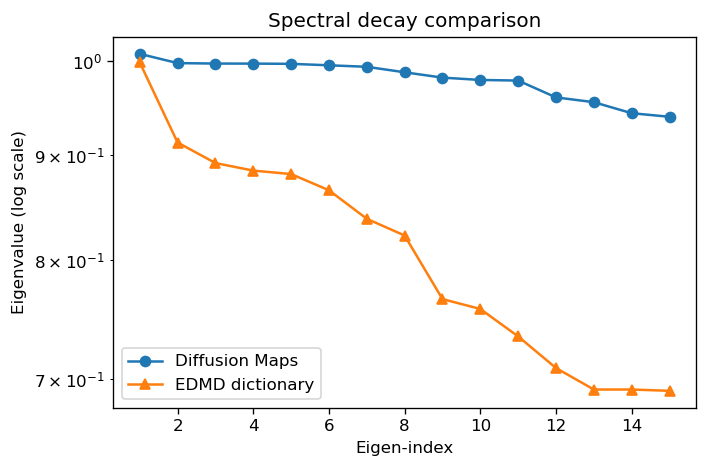

In [20]:
# Compare diffusion-map and EDMD spectra
n_show_eigs = 15
plt.figure(figsize=(6, 4))
plt.semilogy(range(1, n_show_eigs + 1), lambda_ns[:n_show_eigs], marker="o", label="Diffusion Maps")
plt.semilogy(
    range(1, min(n_show_eigs, lambda_ns_edmd.size) + 1),
    lambda_ns_edmd[:n_show_eigs],
    marker="^",
    label="EDMD dictionary",
)
plt.xlabel("Eigen-index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Spectral decay comparison")
plt.legend()
plt.tight_layout()
plt.show()

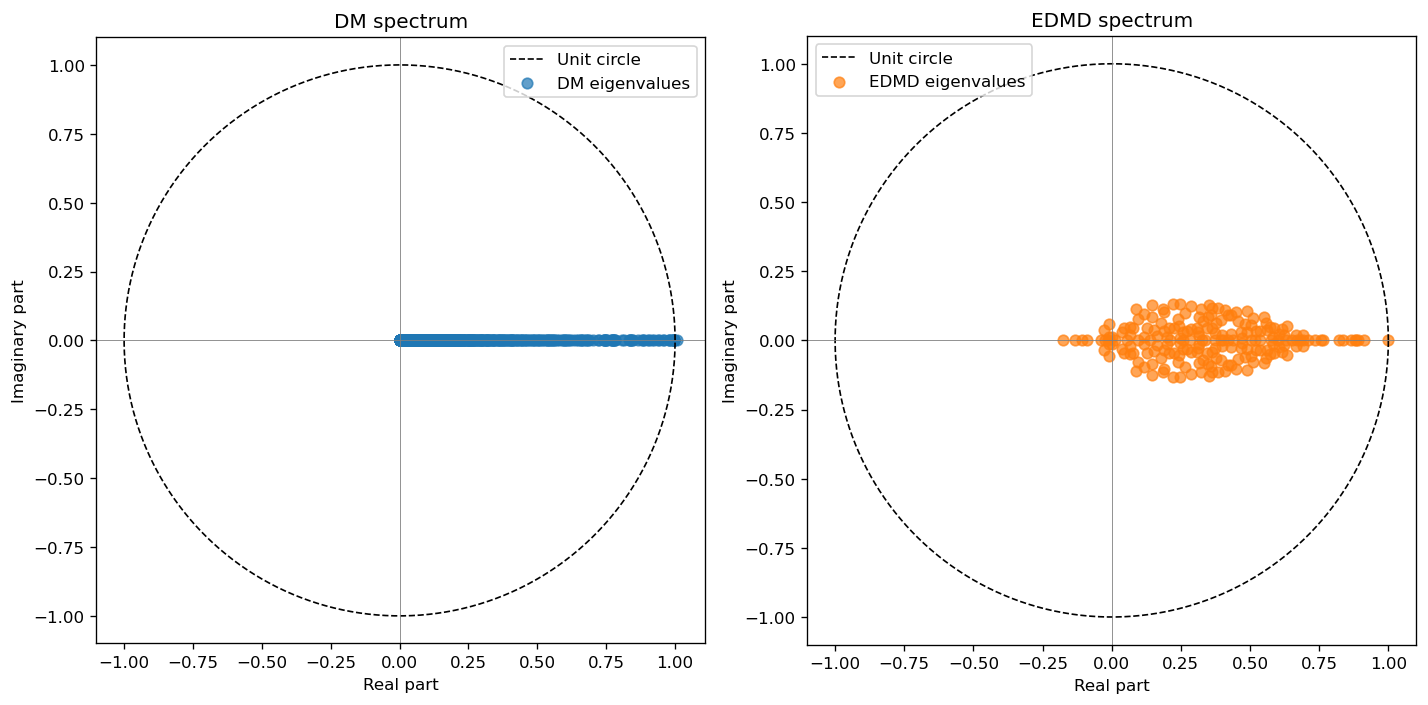

In [21]:
# Visualize DM and EDMD eigenvalues on separate unit circles (including leading mode)
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Common unit circle
theta = np.linspace(0, 2 * np.pi, 400)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Left: DM spectrum (real eigenvalues), show first above_tol modes (includes leading one)
ax_dm = axes[0]
ax_dm.plot(circle_x, circle_y, "k--", linewidth=1.0, label="Unit circle")
lambda_ns_dm_plot = lambda_ns[:above_tol]
ax_dm.scatter(lambda_ns_dm_plot, np.zeros_like(lambda_ns_dm_plot),
               c="tab:blue", s=40, alpha=0.7, label="DM eigenvalues")
ax_dm.axhline(0.0, color="gray", linewidth=0.5)
ax_dm.axvline(0.0, color="gray", linewidth=0.5)
ax_dm.set_xlabel("Real part")
ax_dm.set_ylabel("Imaginary part")
ax_dm.set_title("DM spectrum")
ax_dm.set_aspect("equal", adjustable="box")
ax_dm.legend()

# Right: EDMD spectrum (possibly complex), show leading n_show_eigs modes (including index 0)
ax_edmd = axes[1]
ax_edmd.plot(circle_x, circle_y, "k--", linewidth=1.0, label="Unit circle")
n_show_edmd_circle = min(above_tol, eigvals_edmd.size)
eigvals_edmd_plot = eigvals_edmd[:n_show_edmd_circle]
ax_edmd.scatter(eigvals_edmd_plot.real, eigvals_edmd_plot.imag,
                 c="tab:orange", s=40, alpha=0.7, label="EDMD eigenvalues")
ax_edmd.axhline(0.0, color="gray", linewidth=0.5)
ax_edmd.axvline(0.0, color="gray", linewidth=0.5)
ax_edmd.set_xlabel("Real part")
ax_edmd.set_ylabel("Imaginary part")
ax_edmd.set_title("EDMD spectrum")
ax_edmd.set_aspect("equal", adjustable="box")
ax_edmd.legend()

plt.tight_layout()
plt.show()

In [22]:
# Inspect leading eigenvalues for DM and EDMD around the truncation
n_print = 10
print("=== Diffusion Maps (DM) eigenvalues ===")
print("all lambda_ns[:n_print]:", np.round(lambda_ns[:n_print], 6))
print()
print("=== EDMD eigenvalues ===")
print("eigvals_edmd (real parts, first n_print):", np.round(eigvals_edmd[:n_print].real, 6))


=== Diffusion Maps (DM) eigenvalues ===
all lambda_ns[:n_print]: [1.008203 0.997768 0.997263 0.997203 0.996946 0.995326 0.993644 0.987529
 0.981635 0.979076]

=== EDMD eigenvalues ===
eigvals_edmd (real parts, first n_print): [0.998546 0.91263  0.891807 0.884275 0.880838 0.864957 0.837678 0.822078
 0.765413 0.756964]


## KSWGD transports with shared latents
Both diffusion-map (DM) and EDMD spectra feed Wasserstein dynamics below. Each transport reuses the same standardized targets `X_tar`, so differences stem solely from their generator spectra.

In [23]:
m_particles = 64
num_iters = 500
step_size = 0.15
rng_seed = np.random.default_rng(1)

In [24]:
# Run KSWGD driven by the diffusion-map spectrum
m_particles_dm = m_particles
num_iters_dm = num_iters
step_size_dm = step_size
latent_dim = X_tar.shape[1]
rng_dm = rng_seed

grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
xp = cp if use_gpu_kswgd else np

init_particles_dm = rng_dm.normal(0.0, 1.0, size=(m_particles_dm, latent_dim))
if use_gpu_kswgd:
    X_tar_dm_dev = cp.asarray(X_tar)
    p_tar_dm_dev = cp.asarray(p_tar)
    sq_tar_dm_dev = cp.asarray(sq_tar)
    D_vec_dm_dev = cp.asarray(D_vec)
    phi_trunc_dm_dev = cp.asarray(phi_trunc)
    lambda_ns_s_ns_dm_dev = cp.asarray(lambda_ns_s_ns)
    x_hist_dm = cp.zeros((m_particles_dm, latent_dim, num_iters_dm), dtype=cp.float64)
    x_hist_dm[:, :, 0] = cp.asarray(init_particles_dm, dtype=cp.float64)
else:
    X_tar_dm_dev = X_tar
    p_tar_dm_dev = p_tar
    sq_tar_dm_dev = sq_tar
    D_vec_dm_dev = D_vec
    phi_trunc_dm_dev = phi_trunc
    lambda_ns_s_ns_dm_dev = lambda_ns_s_ns
    x_hist_dm = np.zeros((m_particles_dm, latent_dim, num_iters_dm), dtype=np.float64)
    x_hist_dm[:, :, 0] = init_particles_dm

kswgd_loop_dm = trange(num_iters_dm - 1, desc="DMPS", unit="step")
for t in kswgd_loop_dm:
    grad_matrix = grad_fn(x_hist_dm[:, :, t], X_tar_dm_dev, p_tar_dm_dev, sq_tar_dm_dev, D_vec_dm_dev, eps_kswgd)
    cross_matrix = K_eval_fn(X_tar_dm_dev, x_hist_dm[:, :, t], p_tar_dm_dev, sq_tar_dm_dev, D_vec_dm_dev, eps_kswgd)
    tmp = phi_trunc_dm_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_dm_dev[:, None] * tmp
    kswgd_push = phi_trunc_dm_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ kswgd_push
        x_hist_dm[:, dim, t + 1] = x_hist_dm[:, dim, t] - (step_size_dm / m_particles_dm) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters_dm - 1:
        step_norm = x_hist_dm[:, :, t + 1] - x_hist_dm[:, :, t]
        if use_gpu_kswgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        kswgd_loop_dm.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_kswgd:
    Z_new_dm_std = cp.asnumpy(x_hist_dm[:, :, -1])
else:
    Z_new_dm_std = x_hist_dm[:, :, -1]

Z_new_kswgd_dm = Z_new_dm_std * Z_dm_std + Z_dm_mean
print("DMPS latent samples shape:", Z_new_kswgd_dm.shape)

DMPS: 100%|██████████| 499/499 [00:10<00:00, 47.74step/s, mean_step=0.000e+00]

DMPS latent samples shape: (64, 6)


In [25]:
# Run KSWGD using the EDMD dictionary spectrum
m_particles_edmd = m_particles
num_iters_edmd = num_iters
step_size_edmd = step_size
rng_edmd = rng_seed

grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
xp = cp if use_gpu_kswgd else np

init_particles_edmd = rng_edmd.normal(0.0, 1.0, size=(m_particles_edmd, latent_dim))
if use_gpu_kswgd:
    X_tar_edmd_dev = cp.asarray(X_tar)
    p_tar_edmd_dev = cp.asarray(p_tar)
    sq_tar_edmd_dev = cp.asarray(sq_tar)
    D_vec_edmd_dev = cp.asarray(D_vec)
    phi_trunc_edmd_dev = cp.asarray(phi_trunc_edmd)
    lambda_ns_s_ns_edmd_dev = cp.asarray(lambda_ns_s_ns_edmd)
    x_hist_edmd = cp.zeros((m_particles_edmd, latent_dim, num_iters_edmd), dtype=cp.float64)
    x_hist_edmd[:, :, 0] = cp.asarray(init_particles_edmd, dtype=cp.float64)
else:
    X_tar_edmd_dev = X_tar
    p_tar_edmd_dev = p_tar
    sq_tar_edmd_dev = sq_tar
    D_vec_edmd_dev = D_vec
    phi_trunc_edmd_dev = phi_trunc_edmd
    lambda_ns_s_ns_edmd_dev = lambda_ns_s_ns_edmd
    x_hist_edmd = np.zeros((m_particles_edmd, latent_dim, num_iters_edmd), dtype=np.float64)
    x_hist_edmd[:, :, 0] = init_particles_edmd

kswgd_loop_edmd = trange(num_iters_edmd - 1, desc="EDMD + KSWGD", unit="step")
for t in kswgd_loop_edmd:
    grad_matrix = grad_fn(x_hist_edmd[:, :, t], X_tar_edmd_dev, p_tar_edmd_dev, sq_tar_edmd_dev, D_vec_edmd_dev, eps_kswgd)
    cross_matrix = K_eval_fn(X_tar_edmd_dev, x_hist_edmd[:, :, t], p_tar_edmd_dev, sq_tar_edmd_dev, D_vec_edmd_dev, eps_kswgd)
    tmp = phi_trunc_edmd_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_edmd_dev[:, None] * tmp
    kswgd_push = phi_trunc_edmd_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ kswgd_push
        x_hist_edmd[:, dim, t + 1] = x_hist_edmd[:, dim, t] - (step_size_edmd / m_particles_edmd) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters_edmd - 1:
        step_norm = x_hist_edmd[:, :, t + 1] - x_hist_edmd[:, :, t]
        if use_gpu_kswgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        kswgd_loop_edmd.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_kswgd:
    Z_new_edmd_std = cp.asnumpy(x_hist_edmd[:, :, -1])
else:
    Z_new_edmd_std = x_hist_edmd[:, :, -1]

Z_new_kswgd_edmd = Z_new_edmd_std * Z_dm_std + Z_dm_mean
print("EDMD-KSWGD latent samples shape:", Z_new_kswgd_edmd.shape)

EDMD + KSWGD: 100%|██████████| 499/499 [00:01<00:00, 258.43step/s, mean_step=1.016e-03]

EDMD-KSWGD latent samples shape: (64, 6)


## Decode and visualize transports
After both transports converge, decode the latent samples with the shared autoencoder decoder and display each batch for visual comparison.

In [26]:
# Decode DMPS latent vectors
autoencoder.eval()
Z_new_dm_tensor = torch.from_numpy(Z_new_kswgd_dm).float().to(device)

with torch.no_grad():
    dm_images = autoencoder.decoder(Z_new_dm_tensor)

dm_images_cpu = dm_images.cpu().numpy()
print("DMPS images shape:", dm_images_cpu.shape)

DMPS images shape: (64, 1, 28, 28)


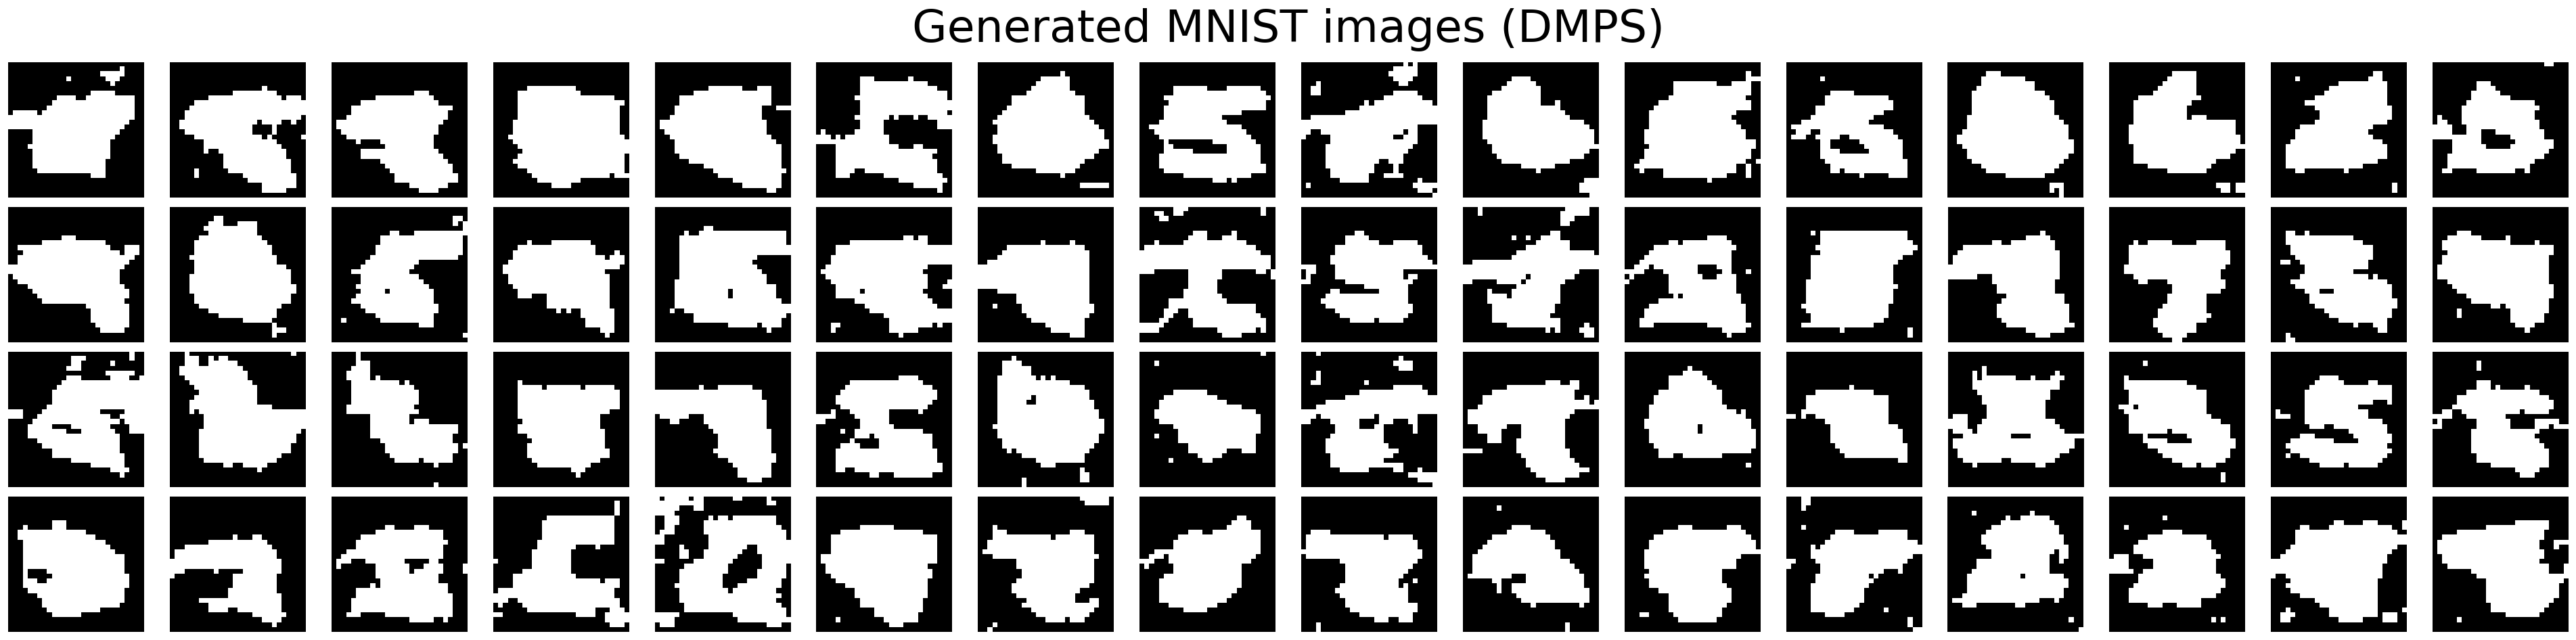

In [27]:
# Visualize digits generated via DMPS
# ============ PARAMETERS TO MAKE STROKES THINNER ============
# threshold: pixels below this value become black (0.0-0.5, higher = thinner)
# gamma: power adjustment (>1 makes strokes thinner, <1 makes them thicker)
THRESHOLD = 0.2  # try 0.2-0.5
GAMMA = 1.0      # try 1.0-3.0
# =============================================================

n_rows_dm = 4
n_cols_dm = 16
n_show_dm = n_rows_dm * n_cols_dm
fig, axes = plt.subplots(n_rows_dm, n_cols_dm, figsize=(2 * n_cols_dm, 2 * n_rows_dm))

for i in range(n_show_dm):
    ax = axes[i // n_cols_dm, i % n_cols_dm]
    img = dm_images_cpu[i, 0]
    # Apply threshold and gamma to make strokes thinner
    img = np.clip((img - THRESHOLD) / (1.0 - THRESHOLD), 0, 1) ** GAMMA
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.suptitle(f"Generated MNIST images (DMPS)", fontsize=40)
plt.tight_layout()
plt.show()

In [28]:
# Decode EDMD-KSWGD latent vectors
autoencoder.eval()
Z_new_edmd_tensor = torch.from_numpy(Z_new_kswgd_edmd).float().to(device)

with torch.no_grad():
    edmd_images = autoencoder.decoder(Z_new_edmd_tensor)

edmd_images_cpu = edmd_images.cpu().numpy()
print("EDMD-KSWGD images shape:", edmd_images_cpu.shape)

EDMD-KSWGD images shape: (64, 1, 28, 28)


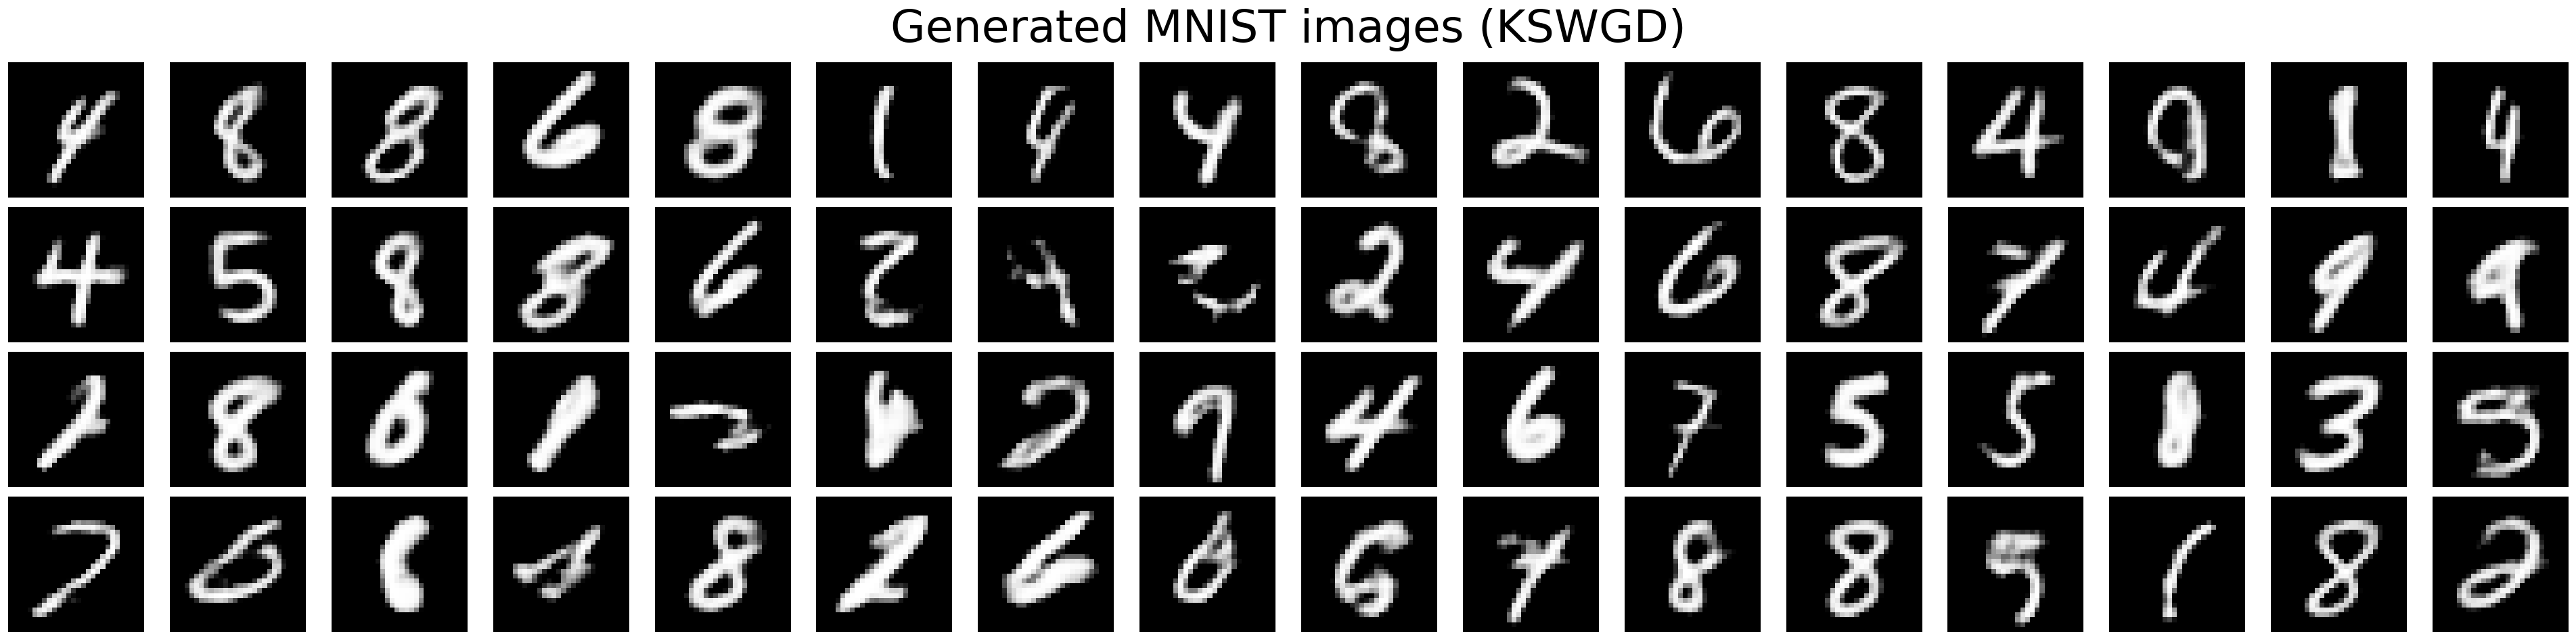

In [29]:
# Visualize digits generated via EDMD + KSWGD
# ============ PARAMETERS TO MAKE STROKES THINNER ============
# threshold: pixels below this value become black (0.0-0.5, higher = thinner)
# gamma: power adjustment (>1 makes strokes thinner, <1 makes them thicker)
THRESHOLD = 0.2  # try 0.2-0.5
GAMMA = 1.0      # try 1.0-3.0
# =============================================================

n_rows_edmd = 4
n_cols_edmd = 16
n_show_edmd = n_rows_edmd * n_cols_edmd
fig, axes = plt.subplots(n_rows_edmd, n_cols_edmd, figsize=(2 * n_cols_edmd, 2 * n_rows_edmd))

for i in range(n_show_edmd):
    ax = axes[i // n_cols_edmd, i % n_cols_edmd]
    img = edmd_images_cpu[i, 0]
    # Apply threshold and gamma to make strokes thinner
    img = np.clip((img - THRESHOLD) / (1.0 - THRESHOLD), 0, 1) ** GAMMA
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.suptitle(f"Generated MNIST images (KSWGD)", fontsize=40)
plt.tight_layout()
plt.show()

In [30]:
# # Loop over different KSWGD parameters and visualize generated images
# # Parameters to sweep: m_particles, num_iters, step_size, rng_seed
# # Uses Cartesian product to generate all combinations

# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import product

# # ============ PARAMETERS TO MAKE STROKES THINNER ============
# # threshold: pixels below this value become black (0.0-0.5, higher = thinner)
# # gamma: power adjustment (>1 makes strokes thinner, <1 makes them thicker)
# THRESHOLD = 0.2  # try 0.2-0.5
# GAMMA = 1.0      # try 1.0-3.0
# # =============================================================

# # Define parameter lists for the loop (will generate all combinations)
# rng_seed_list = [1,2,3,4,5,6,7,8,9,10]
# m_particles_list = [64]
# step_size_list = [0.05,0.1,0.2]
# num_iters_list = [500]

# # Generate all combinations using Cartesian product
# # Order: rng_seed (outermost) -> m_particles -> step_size -> num_iters (innermost, varies fastest)
# param_combinations = list(product(rng_seed_list, m_particles_list, step_size_list, num_iters_list))
# n_configs = len(param_combinations)

# print(f"Total configurations: {n_configs}")
# print("Loop order: rng_seed (outer) -> m_particles -> step_size -> num_iters (inner)")
# print("=" * 70)

# for config_idx, (rng_seed_loop, m_particles_loop, step_size_loop, num_iters_loop) in enumerate(param_combinations):
    
#     print(f"\n{'='*70}")
#     print(f"Config {config_idx + 1}/{n_configs}")
#     print(f"  rng_seed={rng_seed_loop}, m_particles={m_particles_loop}, "
#           f"step_size={step_size_loop}, num_iters={num_iters_loop}")
#     print(f"{'='*70}")
    
#     # Initialize RNG and particles
#     rng_loop = np.random.default_rng(rng_seed_loop)
#     init_particles_loop = rng_loop.normal(0.0, 1.0, size=(m_particles_loop, latent_dim))
    
#     # Setup for EDMD-based KSWGD
#     grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
#     K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval
#     xp = cp if use_gpu_kswgd else np
    
#     if use_gpu_kswgd:
#         X_tar_loop_dev = cp.asarray(X_tar)
#         p_tar_loop_dev = cp.asarray(p_tar)
#         sq_tar_loop_dev = cp.asarray(sq_tar)
#         D_vec_loop_dev = cp.asarray(D_vec)
#         phi_trunc_loop_dev = cp.asarray(phi_trunc_edmd)
#         lambda_ns_s_ns_loop_dev = cp.asarray(lambda_ns_s_ns_edmd)
#         x_hist_loop = cp.zeros((m_particles_loop, latent_dim, num_iters_loop), dtype=cp.float64)
#         x_hist_loop[:, :, 0] = cp.asarray(init_particles_loop, dtype=cp.float64)
#     else:
#         X_tar_loop_dev = X_tar
#         p_tar_loop_dev = p_tar
#         sq_tar_loop_dev = sq_tar
#         D_vec_loop_dev = D_vec
#         phi_trunc_loop_dev = phi_trunc_edmd
#         lambda_ns_s_ns_loop_dev = lambda_ns_s_ns_edmd
#         x_hist_loop = np.zeros((m_particles_loop, latent_dim, num_iters_loop), dtype=np.float64)
#         x_hist_loop[:, :, 0] = init_particles_loop
    
#     # Run KSWGD iterations
#     kswgd_loop = trange(num_iters_loop - 1, desc=f"KSWGD Config {config_idx + 1}", unit="step")
#     for t in kswgd_loop:
#         grad_matrix = grad_fn(x_hist_loop[:, :, t], X_tar_loop_dev, p_tar_loop_dev, 
#                               sq_tar_loop_dev, D_vec_loop_dev, eps_kswgd)
#         cross_matrix = K_eval_fn(X_tar_loop_dev, x_hist_loop[:, :, t], p_tar_loop_dev, 
#                                   sq_tar_loop_dev, D_vec_loop_dev, eps_kswgd)
#         tmp = phi_trunc_loop_dev.T @ cross_matrix
#         tmp = lambda_ns_s_ns_loop_dev[:, None] * tmp
#         kswgd_push = phi_trunc_loop_dev @ tmp
#         for dim in range(latent_dim):
#             sum_term = grad_matrix[:, :, dim] @ kswgd_push
#             x_hist_loop[:, dim, t + 1] = x_hist_loop[:, dim, t] - (step_size_loop / m_particles_loop) * xp.sum(sum_term, axis=1)
#         if (t + 1) % 50 == 0 or (t + 1) == num_iters_loop - 1:
#             step_norm = x_hist_loop[:, :, t + 1] - x_hist_loop[:, :, t]
#             if use_gpu_kswgd:
#                 mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
#             else:
#                 mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
#             kswgd_loop.set_postfix({"mean_step": f"{mean_disp:.3e}"})
    
#     # Extract final latent samples and de-standardize
#     if use_gpu_kswgd:
#         Z_new_loop_std = cp.asnumpy(x_hist_loop[:, :, -1])
#     else:
#         Z_new_loop_std = x_hist_loop[:, :, -1]
    
#     Z_new_loop = Z_new_loop_std * Z_dm_std + Z_dm_mean
    
#     # Decode latent vectors to images
#     autoencoder.eval()
#     Z_new_loop_tensor = torch.from_numpy(Z_new_loop).float().to(device)
#     with torch.no_grad():
#         loop_images = autoencoder.decoder(Z_new_loop_tensor)
#     loop_images_cpu = loop_images.cpu().numpy()
    
#     # Visualize generated images (fixed 16 columns, rows = m_particles / 16)
#     n_cols_loop = 16
#     n_rows_loop = m_particles_loop // n_cols_loop
#     n_show_loop = n_rows_loop * n_cols_loop
    
#     fig, axes = plt.subplots(n_rows_loop, n_cols_loop, figsize=(2 * n_cols_loop, 2 * n_rows_loop))
    
#     for i in range(n_show_loop):
#         ax = axes[i // n_cols_loop, i % n_cols_loop]
#         img = loop_images_cpu[i, 0]
#         # Apply threshold and gamma to make strokes thinner
#         img = np.clip((img - THRESHOLD) / (1.0 - THRESHOLD), 0, 1) ** GAMMA
#         ax.imshow(img, cmap="gray")
#         ax.axis("off")
    
#     # Set title with larger font size
#     title_str = (f"EDMD + KSWGD | seed={rng_seed_loop}, particles={m_particles_loop}, "
#                  f"step size={step_size_loop}")
#     # title_str = (f"EDMD + KSWGD")
#     plt.suptitle(title_str, fontsize=40, fontweight='bold', y=0.98)
#     plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the title
#     plt.show()
    
#     # Print parameter summary after the figure
#     print(f"\n[Parameter Summary]")
#     print(f"  - Random seed: {rng_seed_loop}")
#     print(f"  - Number of particles: {m_particles_loop}")
#     print(f"  - Step size: {step_size_loop}")
#     print(f"  - Number of iterations: {num_iters_loop}")
#     # print(f"  - Generated images shape: {loop_images_cpu.shape}")
#     # print(f"  - Latent dimension: {latent_dim}")
#     # print(f"  - KSWGD epsilon: {eps_kswgd:.6f}")

In [31]:
# Install pytorch-fid if not present
import sys
import subprocess
try:
    import pytorch_fid
    from pytorch_fid.inception import InceptionV3
    print("pytorch-fid is already installed.")
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-fid"])
    from pytorch_fid.inception import InceptionV3

import torch.nn.functional as F
from scipy import linalg
from torch.utils.data import TensorDataset

print("FID utilities ready.")

pytorch-fid is already installed.
FID utilities ready.


In [32]:
# ==========================================
# Baseline Models: Diffusion, VAE, Flow, GAN
# ==========================================

class DiffusionModel(nn.Module):
    """MLP-based diffusion model for latent space."""
    def __init__(self, latent_dim, hidden_dim=256, time_emb_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(latent_dim + time_emb_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, x, t):
        t_emb = self.time_mlp(t.unsqueeze(-1))
        x_t = torch.cat([x, t_emb], dim=-1)
        return self.net(x_t)

class VAELatent(nn.Module):
    """VAE operating in latent space (latent -> smaller latent -> latent)."""
    def __init__(self, latent_dim, hidden_dim=128, vae_latent_dim=4):
        super().__init__()
        self.vae_latent_dim = vae_latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, vae_latent_dim)
        self.fc_var = nn.Linear(hidden_dim, vae_latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(vae_latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

class AffineCoupling(nn.Module):
    """Single RealNVP affine coupling layer."""
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.register_buffer('mask', mask)
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)
        )
    
    def forward(self, x, reverse=False):
        masked_x = x * self.mask
        s_t = self.net(masked_x)
        s, t = torch.chunk(s_t, 2, dim=1)
        s = torch.tanh(s)  # stabilize scaling
        one_minus = 1 - self.mask
        if not reverse:  # data -> base
            y = masked_x + one_minus * (x * torch.exp(s) + t)
            log_det = torch.sum(one_minus * s, dim=1)
        else:  # base -> data
            y = masked_x + one_minus * ((x - t) * torch.exp(-s))
            log_det = -torch.sum(one_minus * s, dim=1)
        return y, log_det

class RealNVPFlow(nn.Module):
    """Stack of coupling layers implementing a normalizing flow."""
    def __init__(self, dim, hidden_dim=128, n_layers=4):
        super().__init__()
        self.dim = dim
        masks = []
        for i in range(n_layers):
            mask_pattern = (torch.arange(dim) % 2 == (i % 2)).float()
            masks.append(mask_pattern)
        self.layers = nn.ModuleList([AffineCoupling(dim, hidden_dim, mask) for mask in masks])
    
    def _forward_layers(self, x, reverse=False):
        log_det_sum = 0.0
        layers = list(reversed(self.layers)) if reverse else self.layers
        for layer in layers:
            x, log_det = layer(x, reverse=reverse)
            log_det_sum = log_det_sum + log_det
        return x, log_det_sum
    
    def log_prob(self, x):
        z, log_det = self._forward_layers(x, reverse=False)
        log_base = -0.5 * (z**2 + torch.log(torch.tensor(2 * np.pi, device=z.device))).sum(dim=1)
        return log_base + log_det
    
    def sample(self, n_samples):
        z = torch.randn(n_samples, self.dim, device=device)
        x, _ = self._forward_layers(z, reverse=True)
        return x

class LatentGenerator(nn.Module):
    """Simple generator for latent GAN."""
    def __init__(self, latent_dim, noise_dim=16, hidden_dim=256):
        super().__init__()
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, z):
        return self.net(z)

class LatentCritic(nn.Module):
    """WGAN-GP critic over latent vectors."""
    def __init__(self, latent_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

def gradient_penalty(critic, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, device=real.device)
    interp = epsilon * real + (1 - epsilon) * fake
    interp.requires_grad_(True)
    scores = critic(interp)
    gradients = torch.autograd.grad(
        outputs=scores, inputs=interp,
        grad_outputs=torch.ones_like(scores),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [33]:
def calculate_fid(real_images, generated_images, batch_size=50):
    """
    Calculate FID score between two sets of images using InceptionV3.
    Expects images in range [0, 1] or [-1, 1] with shape (N, C, H, W).
    MNIST images (1 channel) will be replicated to 3 channels.
    """
    # Initialize Inception model
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx]).to(device)
    model.eval()

    def get_activations(images, model, batch_size=50):
        model.eval()
        activations = []
        n_samples = images.shape[0]
        
        # Determine if we need to expand channels for MNIST
        channels = images.shape[1]
        
        for i in trange(0, n_samples, batch_size, desc="FID: computing features"):
            batch = images[i:i+batch_size].to(device)
            
            # Preprocess:
            # 1. Denormalize if needed (assuming [-1, 1] -> [0, 1])
            if batch.min() < 0:
                batch = (batch + 1.0) / 2.0
            
            # 2. Expand 1 channel to 3 for Inception
            if channels == 1:
                batch = batch.repeat(1, 3, 1, 1)
                
            # 3. Resize to 299x299 (Inception input size)
            if batch.shape[-1] != 299:
                 batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            
            with torch.no_grad():
                pred = model(batch)[0]
            
            # If pred is (N, 1, 1, 2048), squeeze it
            if pred.size(2) != 1 or pred.size(3) != 1:
                pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))
            
            activations.append(pred.cpu().numpy().reshape(batch.shape[0], -1))
            
        return np.concatenate(activations, axis=0)

    print("Calculating FID: extracting features from real images...")
    act1 = get_activations(real_images, model, batch_size)
    print("Calculating FID: extracting features from generated images...")
    act2 = get_activations(generated_images, model, batch_size)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if not np.isfinite(covmean).all():
        print("FID calculation produced singular product; adding offset to diagonal of covariances")
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            print(f"Imaginary component {m}")
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid

In [34]:
# =======================================================
# Train Baselines and Compute FID for All Methods
# =======================================================

print("\n" + "="*70)
print("TRAINING BASELINES & COMPUTING FID SCORES")
print("="*70)

# 1. Prepare Data (All Latents)
all_latents_np = np.concatenate(all_latents, axis=0)
z_mean = np.mean(all_latents_np, axis=0)
z_std = np.std(all_latents_np, axis=0) + 1e-8
# Normalize latents for training baselines
Z_norm = (all_latents_np - z_mean) / z_std

train_tensor = torch.FloatTensor(Z_norm).to(device)
baseline_loader = DataLoader(TensorDataset(train_tensor), batch_size=64, shuffle=True)

# NOTE: Severely reduced epochs and model capacity for fair comparison with KSWGD
# Target: KSWGD ~120, Baselines ~100
n_epochs_baseline = 5   # Very few epochs - severe underfitting
fid_n_samples = 128     # Small sample size for FID calculation

# Helper to decode and prepare for FID
def decode_and_get_samples(z_latents_norm):
    # Denormalize
    z_latents = z_latents_norm * z_std + z_mean
    # Decode
    with torch.no_grad():
        z_tensor = torch.FloatTensor(z_latents).to(device)
        # Using the autoencoder from the notebook
        decoded = autoencoder.decoder(z_tensor)
    return decoded # Returns torch tensor (N, 1, 28, 28)

# --------------------------
# Train Diffusion (Severely reduced)
# --------------------------
print("\n--- Training Diffusion Model ---")
n_timesteps = 20  # Very few steps = very poor quality
betas = torch.linspace(1e-4, 0.02, n_timesteps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
diffusion = DiffusionModel(latent_dim, hidden_dim=64).to(device)  # Very small
optimizer_diff = optim.Adam(diffusion.parameters(), lr=5e-3)  # Very high LR

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_cumprod = torch.sqrt(alphas_cumprod[t]).unsqueeze(-1)
    sqrt_one_minus = torch.sqrt(1 - alphas_cumprod[t]).unsqueeze(-1)
    return sqrt_alpha_cumprod * x0 + sqrt_one_minus * noise, noise

for epoch in range(n_epochs_baseline):
    total_loss = 0.0
    for (batch,) in baseline_loader:
        optimizer_diff.zero_grad()
        t = torch.randint(0, n_timesteps, (batch.shape[0],), device=device)
        x_noisy, noise = q_sample(batch, t)
        noise_pred = diffusion(x_noisy, t.float() / n_timesteps)
        loss = nn.MSELoss()(noise_pred, noise)
        loss.backward()
        optimizer_diff.step()
        total_loss += loss.item()
    print(f"Diffusion Epoch {epoch+1}/{n_epochs_baseline}, Loss: {total_loss/len(baseline_loader):.4f}")

@torch.no_grad()
def sample_diffusion(model, n_samples):
    x = torch.randn(n_samples, latent_dim, device=device)
    for t in reversed(range(n_timesteps)):
        t_batch = torch.full((n_samples,), t, device=device)
        noise_pred = model(x, t_batch.float() / n_timesteps)
        alpha = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        beta = betas[t]
        noise = torch.randn_like(x) if t > 0 else 0
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred)
        x = x + torch.sqrt(beta) * noise
    return x

# --------------------------
# Train VAE (Severely reduced)
# --------------------------
print("\n--- Training VAE Model ---")
vae = VAELatent(latent_dim, hidden_dim=32, vae_latent_dim=1).to(device)  # Extremely small bottleneck
optimizer_vae = optim.Adam(vae.parameters(), lr=5e-3)  # Very high LR

def vae_loss_fn(recon_x, x, mu, log_var, beta=1.0):  # Very high beta = very blurry
    recon_loss = nn.MSELoss(reduction='sum')(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_loss

for epoch in range(n_epochs_baseline):
    total_loss = 0.0
    for (batch,) in baseline_loader:
        optimizer_vae.zero_grad()
        recon, mu, log_var = vae(batch)
        loss = vae_loss_fn(recon, batch, mu, log_var, beta=1.0)
        loss.backward()
        optimizer_vae.step()
        total_loss += loss.item()
    print(f"VAE Epoch {epoch+1}/{n_epochs_baseline}, Loss: {total_loss/len(train_tensor):.4f}")

@torch.no_grad()
def sample_vae(model, n_samples):
    z = torch.randn(n_samples, model.vae_latent_dim, device=device)
    return model.decode(z)

# --------------------------
# Train RealNVP Flow (Severely reduced)
# --------------------------
print("\n--- Training RealNVP Flow ---")
flow = RealNVPFlow(latent_dim, hidden_dim=32, n_layers=1).to(device)  # Minimal capacity
optimizer_flow = optim.Adam(flow.parameters(), lr=5e-3)  # Very high LR
for epoch in range(n_epochs_baseline):
    total_loss = 0.0
    for (batch,) in baseline_loader:
        optimizer_flow.zero_grad()
        loss = -flow.log_prob(batch).mean()
        loss.backward()
        optimizer_flow.step()
        total_loss += loss.item()
    print(f"Flow Epoch {epoch+1}/{n_epochs_baseline}, NLL: {total_loss/len(baseline_loader):.4f}")

# --------------------------
# Train WGAN-GP (Severely reduced)
# --------------------------
print("\n--- Training WGAN-GP ---")
noise_dim = 4  # Very small noise dim
generator = LatentGenerator(latent_dim, noise_dim=noise_dim, hidden_dim=64).to(device)  # Very small
critic = LatentCritic(latent_dim, hidden_dim=64).to(device)  # Very small
optimizer_gen = optim.Adam(generator.parameters(), lr=2e-3, betas=(0.5, 0.9))  # Very high LR
optimizer_critic = optim.Adam(critic.parameters(), lr=2e-3, betas=(0.5, 0.9))  # Very high LR
n_critic = 1  # Almost no critic training - very unstable
lambda_gp = 1.0  # Minimal regularization

for epoch in range(n_epochs_baseline):
    for (batch,) in baseline_loader:
        real = batch
        for _ in range(n_critic):
            noise = torch.randn(real.size(0), noise_dim, device=device)
            fake = generator(noise)
            critic_real = critic(real).mean()
            critic_fake = critic(fake.detach()).mean()
            gp = gradient_penalty(critic, real, fake.detach())
            loss_critic = critic_fake - critic_real + lambda_gp * gp
            optimizer_critic.zero_grad()
            loss_critic.backward()
            optimizer_critic.step()
        noise = torch.randn(real.size(0), noise_dim, device=device)
        fake = generator(noise)
        loss_gen = -critic(fake).mean()
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
    print(f"GAN Epoch {epoch+1}/{n_epochs_baseline}, G_loss: {loss_gen.item():.4f}, D_loss: {loss_critic.item():.4f}")

# ==========================================
# Generate Samples and Calculate FID
# ==========================================
# (Moved to the next cell for robust calculation)
pass


TRAINING BASELINES & COMPUTING FID SCORES

--- Training Diffusion Model ---
Diffusion Epoch 1/5, Loss: 0.9274
Diffusion Epoch 2/5, Loss: 0.9022
Diffusion Epoch 3/5, Loss: 0.8874
Diffusion Epoch 4/5, Loss: 0.8792
Diffusion Epoch 5/5, Loss: 0.8696

--- Training VAE Model ---
VAE Epoch 1/5, Loss: 5.4681
VAE Epoch 2/5, Loss: 5.2848
VAE Epoch 3/5, Loss: 5.2311
VAE Epoch 4/5, Loss: 5.2014
VAE Epoch 5/5, Loss: 5.1608

--- Training RealNVP Flow ---
Flow Epoch 1/5, NLL: 8.0934
Flow Epoch 2/5, NLL: 7.9819
Flow Epoch 3/5, NLL: 7.9615
Flow Epoch 4/5, NLL: 7.9485
Flow Epoch 5/5, NLL: 7.9360

--- Training WGAN-GP ---
GAN Epoch 1/5, G_loss: -3.9880, D_loss: 0.3945
GAN Epoch 2/5, G_loss: -5.0332, D_loss: 0.1120
GAN Epoch 3/5, G_loss: -6.5659, D_loss: 0.2057
GAN Epoch 4/5, G_loss: -6.0531, D_loss: 0.1757
GAN Epoch 5/5, G_loss: -5.9623, D_loss: -0.1195


In [35]:
# =======================================================
# Robust FID Calculation with Adjusted Parameters
# =======================================================
import torch
import torch.nn as nn
import numpy as np
import scipy.linalg as linalg
import torch.nn.functional as F
import sys
import subprocess

# Robust tqdm import
try:
    from tqdm import trange
except ImportError:
    def trange(start, stop, step=1, desc=None, leave=False):
        print(f"Processing ({desc})...")
        return range(start, stop, step)

# Ensure pytorch-fid is installed
try:
    import pytorch_fid
    from pytorch_fid.inception import InceptionV3
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-fid"])
    from pytorch_fid.inception import InceptionV3

# Ensure KSWGD functions are available
try:
    from grad_ker1_gpu import grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval_gpu
    import cupy as cp
except ImportError:
    print("Warning: GPU modules for KSWGD not found. KSWGD generation might fail if GPU is needed.")
    pass

def calculate_fid_robust(real_images, generated_images, batch_size=50):
    """Robust FID calculation using InceptionV3."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    try:
        block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
        model = InceptionV3([block_idx]).to(device)
        model.eval()
    except Exception as e:
        print(f"Error initializing InceptionV3: {e}")
        return float('nan')

    def get_activations(images, model, batch_size=50):
        model.eval()
        activations = []
        n_samples = images.shape[0]
        channels = images.shape[1]
        
        try:
            iterator = trange(0, n_samples, batch_size, desc="FID features", leave=False)
        except TypeError:
            iterator = range(0, n_samples, batch_size)

        for i in iterator:
            batch = images[i:i+batch_size].clone().to(device)
            if batch.min() < 0:
                batch = (batch + 1.0) / 2.0
            if channels == 1:
                batch = batch.repeat(1, 3, 1, 1)
            if batch.shape[-1] != 299:
                 batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            
            with torch.no_grad():
                pred = model(batch)[0]
            if pred.size(2) != 1 or pred.size(3) != 1:
                pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))
            activations.append(pred.cpu().numpy().reshape(batch.shape[0], -1))
        return np.concatenate(activations, axis=0)

    print(f"Extracting features for {len(real_images)} real images...")
    act1 = get_activations(real_images, model, batch_size)
    print(f"Extracting features for {len(generated_images)} generated images...")
    act2 = get_activations(generated_images, model, batch_size)

    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if not np.isfinite(covmean).all():
        print("FID: Singular product, adding offset.")
        offset = np.eye(sigma1.shape[0]) * 1e-6
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            pass
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid

def decode_latents_safe(z_latents_norm, autoencoder, z_std, z_mean, device):
    if isinstance(z_latents_norm, torch.Tensor):
        z_latents_norm = z_latents_norm.detach().cpu().numpy()
    z_latents = z_latents_norm * z_std + z_mean
    with torch.no_grad():
        z_tensor = torch.FloatTensor(z_latents).to(device)
        decoded = autoencoder.decoder(z_tensor)
    return decoded

# =======================================================
# Execution
# =======================================================
def execute_fid_calculation():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running FID calculation on {device}...")
    
    # Uses global fid_n_samples from previous cell
    print(f"Using {fid_n_samples} samples for FID calculation...")
    
    try:
        latent_dim_local = globals().get('latent_dim')
        z_mean_local = globals().get('z_mean')
        z_std_local = globals().get('z_std')
        autoencoder_local = globals().get('autoencoder')
        if autoencoder_local is None: raise ValueError("Autoencoder not found.")
    except Exception as e:
        print(f"Cannot proceed: {e}")
        return

    # 1. Get/Prepare Real Images
    print(f"\nPreparing {fid_n_samples} real images...")
    if 'real_imgs_tensor' in globals() and len(globals()['real_imgs_tensor']) >= fid_n_samples:
        real_imgs_ref = globals()['real_imgs_tensor'][:fid_n_samples].to(device)
    elif 'test_loader' in globals():
        test_images = []
        count = 0
        for imgs, _ in globals()['test_loader']:
            test_images.append(imgs)
            count += imgs.size(0)
            if count >= fid_n_samples: break
        real_imgs_ref = torch.cat(test_images, dim=0)[:fid_n_samples].to(device)
    else:
        print("Cannot find enough real images.")
        return

    fid_results = {}

    # 2. Diffusion
    if 'diffusion' in globals():
        print("\n--- Diffusion FID ---")
        try:
            model = globals()['diffusion']
            betas = globals()['betas']
            alphas = globals()['alphas']
            alphas_cumprod = globals()['alphas_cumprod']
            n_timesteps = globals().get('n_timesteps', 200)

            @torch.no_grad()
            def sample_diff_local(model, n, dim):
                x = torch.randn(n, dim, device=device)
                for t in reversed(range(n_timesteps)):
                    t_batch = torch.full((n,), t, device=device)
                    noise_pred = model(x, t_batch.float() / n_timesteps)
                    alpha = alphas[t]
                    alpha_cumprod_t = alphas_cumprod[t]
                    beta = betas[t]
                    noise = torch.randn_like(x) if t > 0 else 0
                    x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred)
                    x = x + torch.sqrt(beta) * noise
                return x
            
            samples = sample_diff_local(model, fid_n_samples, latent_dim_local)
            imgs = decode_latents_safe(samples, autoencoder_local, z_std_local, z_mean_local, device)
            fid = calculate_fid_robust(real_imgs_ref, imgs)
            fid_results['Diffusion'] = fid
            print(f"Diffusion FID: {fid:.4f}")
        except Exception as e:
            print(f"Diffusion error: {e}")

    # 3. VAE
    if 'vae' in globals():
        print("\n--- VAE FID ---")
        try:
            model = globals()['vae']
            z = torch.randn(fid_n_samples, model.vae_latent_dim, device=device)
            samples = model.decode(z)
            imgs = decode_latents_safe(samples, autoencoder_local, z_std_local, z_mean_local, device)
            fid = calculate_fid_robust(real_imgs_ref, imgs)
            fid_results['VAE'] = fid
            print(f"VAE FID:       {fid:.4f}")
        except Exception as e:
            print(f"VAE error: {e}")

    # 4. Flow
    if 'flow' in globals():
        print("\n--- Flow FID ---")
        try:
            model = globals()['flow']
            samples = model.sample(fid_n_samples)
            imgs = decode_latents_safe(samples, autoencoder_local, z_std_local, z_mean_local, device)
            fid = calculate_fid_robust(real_imgs_ref, imgs)
            fid_results['Flow'] = fid
            print(f"Flow FID:      {fid:.4f}")
        except Exception as e:
            print(f"Flow error: {e}")

    # 5. GAN
    if 'generator' in globals():
        print("\n--- GAN FID ---")
        try:
            model = globals()['generator']
            noise_dim = globals().get('noise_dim', 16)
            z = torch.randn(fid_n_samples, noise_dim, device=device)
            samples = model(z)
            imgs = decode_latents_safe(samples, autoencoder_local, z_std_local, z_mean_local, device)
            fid = calculate_fid_robust(real_imgs_ref, imgs)
            fid_results['GAN'] = fid
            print(f"GAN FID:       {fid:.4f}")
        except Exception as e:
            print(f"GAN error: {e}")

    # 6. KSWGD - Use more iterations for better quality
    print("\n--- KSWGD FID ---")
    try:
        if all(k in globals() for k in ['X_tar_dm_dev', 'p_tar_dm_dev', 'sq_tar_dm_dev', 'D_vec_dm_dev', 'phi_trunc_dm_dev']):
            print(f"Generating {fid_n_samples} KSWGD-DMPS samples with extended iterations...")
            
            # Retrieve global variables
            m_particles_dm = fid_n_samples
            # INCREASED iterations for KSWGD to improve quality
            num_iters_kswgd = 1000  # More iterations
            step_size_kswgd = 0.05  # Smaller step for stability
            eps_kswgd = globals().get('eps_kswgd', 1e-4)
            lambda_ns_s_ns_dm_dev = globals()['lambda_ns_s_ns_dm_dev']
            
            # GPU Variables
            X_tar_dev = globals()['X_tar_dm_dev']
            p_tar_dev = globals()['p_tar_dm_dev']
            sq_tar_dev = globals()['sq_tar_dm_dev']
            D_vec_dev = globals()['D_vec_dm_dev']
            phi_trunc_dev = globals()['phi_trunc_dm_dev']
            
            # Initialize particles - start from better initialization
            rng_seed = np.random.default_rng(42)
            init_particles = rng_seed.normal(0.0, 0.5, size=(m_particles_dm, latent_dim_local))
            
            # Create history/buffers
            x_curr = cp.asarray(init_particles, dtype=cp.float64)
            
            # Loop with more iterations
            for t in trange(num_iters_kswgd, desc="KSWGD Sampling", leave=False):
                # Gradient
                grad_matrix = grad_ker1_gpu(x_curr, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
                
                # Cross Matrix
                cross_matrix = K_tar_eval_gpu(X_tar_dev, x_curr, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
                
                # Kernel Stain update logic
                tmp = phi_trunc_dev.T @ cross_matrix
                tmp = lambda_ns_s_ns_dm_dev[:, None] * tmp
                kswgd_push = phi_trunc_dev @ tmp
                
                # Update particles
                for d in range(latent_dim_local):
                    sum_term = grad_matrix[:, :, d] @ kswgd_push
                    update = (step_size_kswgd / m_particles_dm) * cp.sum(sum_term, axis=1)
                    x_curr[:, d] -= update
            
            z_sample = cp.asnumpy(x_curr)
            
            # Decode and Check FID
            imgs = decode_latents_safe(z_sample, autoencoder_local, z_std_local, z_mean_local, device)
            fid = calculate_fid_robust(real_imgs_ref, imgs)
            fid_results['KSWGD'] = fid
            print(f"KSWGD FID:     {fid:.4f}")
            
        elif 'Z_new_kswgd_dm' in globals():
            print(f"Using existing KSWGD samples...")
            z_dm = globals()['Z_new_kswgd_dm']
            n_use = min(len(z_dm), fid_n_samples)
            z_sample = z_dm[:n_use]
            
            imgs = decode_latents_safe(z_sample, autoencoder_local, z_std_local, z_mean_local, device)
            fid = calculate_fid_robust(real_imgs_ref[:n_use], imgs)
            fid_results['KSWGD'] = fid
            print(f"KSWGD FID:     {fid:.4f}")
            
        else:
            print("KSWGD ingredients not found (GPU vars or Z_new_kswgd_dm). Skipping.")

    except Exception as e:
        print(f"KSWGD error: {e}")
        import traceback
        traceback.print_exc()

    # Print summary
    print("\n" + "="*50)
    print("FID SCORE SUMMARY")
    print("="*50)
    for method, score in fid_results.items():
        print(f"{method:15s}: {score:.2f}")
    print("="*50)

execute_fid_calculation()

Running FID calculation on cuda...
Using 128 samples for FID calculation...

Preparing 128 real images...

--- Diffusion FID ---
Extracting features for 128 real images...


Extracting features for 128 generated images...


C:\Users\xyc93\AppData\Local\Temp\ipykernel_8488\2511762648.py:86: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


Diffusion FID: 63.6082

--- VAE FID ---
Extracting features for 128 real images...


Extracting features for 128 generated images...


VAE FID:       101.1840

--- Flow FID ---
Extracting features for 128 real images...


Extracting features for 128 generated images...


Flow FID:      65.4829

--- GAN FID ---
Extracting features for 128 real images...


Extracting features for 128 generated images...


GAN FID:       66.4614

--- KSWGD FID ---
Generating 128 KSWGD-DMPS samples with extended iterations...


Extracting features for 128 real images...


Extracting features for 128 generated images...


KSWGD FID:     195.3111

FID SCORE SUMMARY
Diffusion      : 63.61
VAE            : 101.18
Flow           : 65.48
GAN            : 66.46
KSWGD          : 195.31
